<a href="https://colab.research.google.com/github/mythogenesys/ecg-denoiser-hackathon/blob/main/notebooks/eeg-generalization-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: EEG Generalization Study (All-in-One)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pyedflib
import os
import requests
import random




In [ ]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.9 MB/s eta 0:00:00


In [ ]:
# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_FS = 256
SEGMENT_SAMPLES = 1024  # 4 seconds at 256 Hz
EEG_FILE_URL = "https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf?download"
EEG_FILENAME = "chb01_03.edf"
SEIZURE_START_S = 2996  # Start of seizure in seconds in chb01_03
SEIZURE_END_S = 3036    # End of seizure
TRAINING_EPOCHS = 20
BATCH_SIZE = 32

print(f"Using device: {DEVICE}")



Using device: cuda


In [ ]:
# --- Lightweight 1D U-Net Model ---
# (Using the same model architecture for a fair comparison)
class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet1D, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.pool = nn.MaxPool1d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out = nn.Conv1d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        b = self.bottleneck(p2)

        u2 = self.upconv2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return self.out(d1)

# --- STPC Loss Functions (same as before) ---
class GradientLoss(nn.Module):
    def __init__(self):
        super(GradientLoss, self).__init__()
        self.loss = nn.L1Loss()
    def forward(self, pred, target):
        return self.loss(torch.diff(pred, dim=-1), torch.diff(target, dim=-1))

class FFTLoss(nn.Module):
    def __init__(self):
        super(FFTLoss, self).__init__()
        self.loss = nn.L1Loss()
    def forward(self, pred, target):
        pred_fft_mag = torch.abs(torch.fft.fft(pred, dim=-1))
        target_fft_mag = torch.abs(torch.fft.fft(target, dim=-1))
        return self.loss(pred_fft_mag, target_fft_mag)

# --- Data Loading and Preparation ---
print(f"Downloading EEG data file: {EEG_FILENAME}...")
with open(EEG_FILENAME, "wb") as f:
    response = requests.get(EEG_FILE_URL, stream=True)
    total_length = response.headers.get('content-length')
    if total_length is None:
        f.write(response.content)
    else:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
print("Download complete.")



Download complete.


In [ ]:
f = pyedflib.EdfReader(EEG_FILENAME)
# Let's use channel F4-C4 as it often shows clear seizure activity
channel_index = 7
original_fs = f.getSampleFrequency(channel_index)
eeg_signal = f.readSignal(channel_index)
f._close()

# Resample to target frequency
resample_ratio = TARGET_FS / original_fs
num_samples_resampled = int(len(eeg_signal) * resample_ratio)
eeg_signal_resampled = np.interp(
    np.linspace(0.0, len(eeg_signal), num_samples_resampled),
    np.arange(len(eeg_signal)),
    eeg_signal
)
eeg_signal = (eeg_signal_resampled - np.mean(eeg_signal_resampled)) / np.std(eeg_signal_resampled)
print(f"EEG Signal loaded and preprocessed. Length: {len(eeg_signal)} samples.")



EEG Signal loaded and preprocessed. Length: 921600 samples.


In [ ]:
# Create dataset: windows of seizure and non-seizure activity
seizure_start_sample = SEIZURE_START_S * TARGET_FS
seizure_end_sample = SEIZURE_END_S * TARGET_FS
clean_segments = []
for i in range(0, len(eeg_signal) - SEGMENT_SAMPLES, SEGMENT_SAMPLES):
    # Take segments from before, during, and after the seizure
    if (i < seizure_start_sample - (60 * TARGET_FS)) or \
       (i > seizure_start_sample and i < seizure_end_sample) or \
       (i > seizure_end_sample + (60*TARGET_FS)):
        clean_segments.append(eeg_signal[i:i+SEGMENT_SAMPLES])



In [ ]:
class EEGDataset(Dataset):
    def __init__(self, segments, num_samples):
        self.segments = segments
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        clean = random.choice(self.segments)
        noise = np.random.randn(len(clean)) * np.mean(np.abs(clean)) * random.uniform(0.5, 2.0)
        noisy = clean + noise
        return torch.from_numpy(noisy).float().unsqueeze(0), torch.from_numpy(clean).float().unsqueeze(0)

train_dataset = EEGDataset(clean_segments, num_samples=5000)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)




--- Training model with STPC=Disabled ---


Epoch 1/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/157 [00:00<?, ?it/s]


--- Training model with STPC=Enabled ---


Epoch 1/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/157 [00:00<?, ?it/s]


--- Generating final comparison plot ---


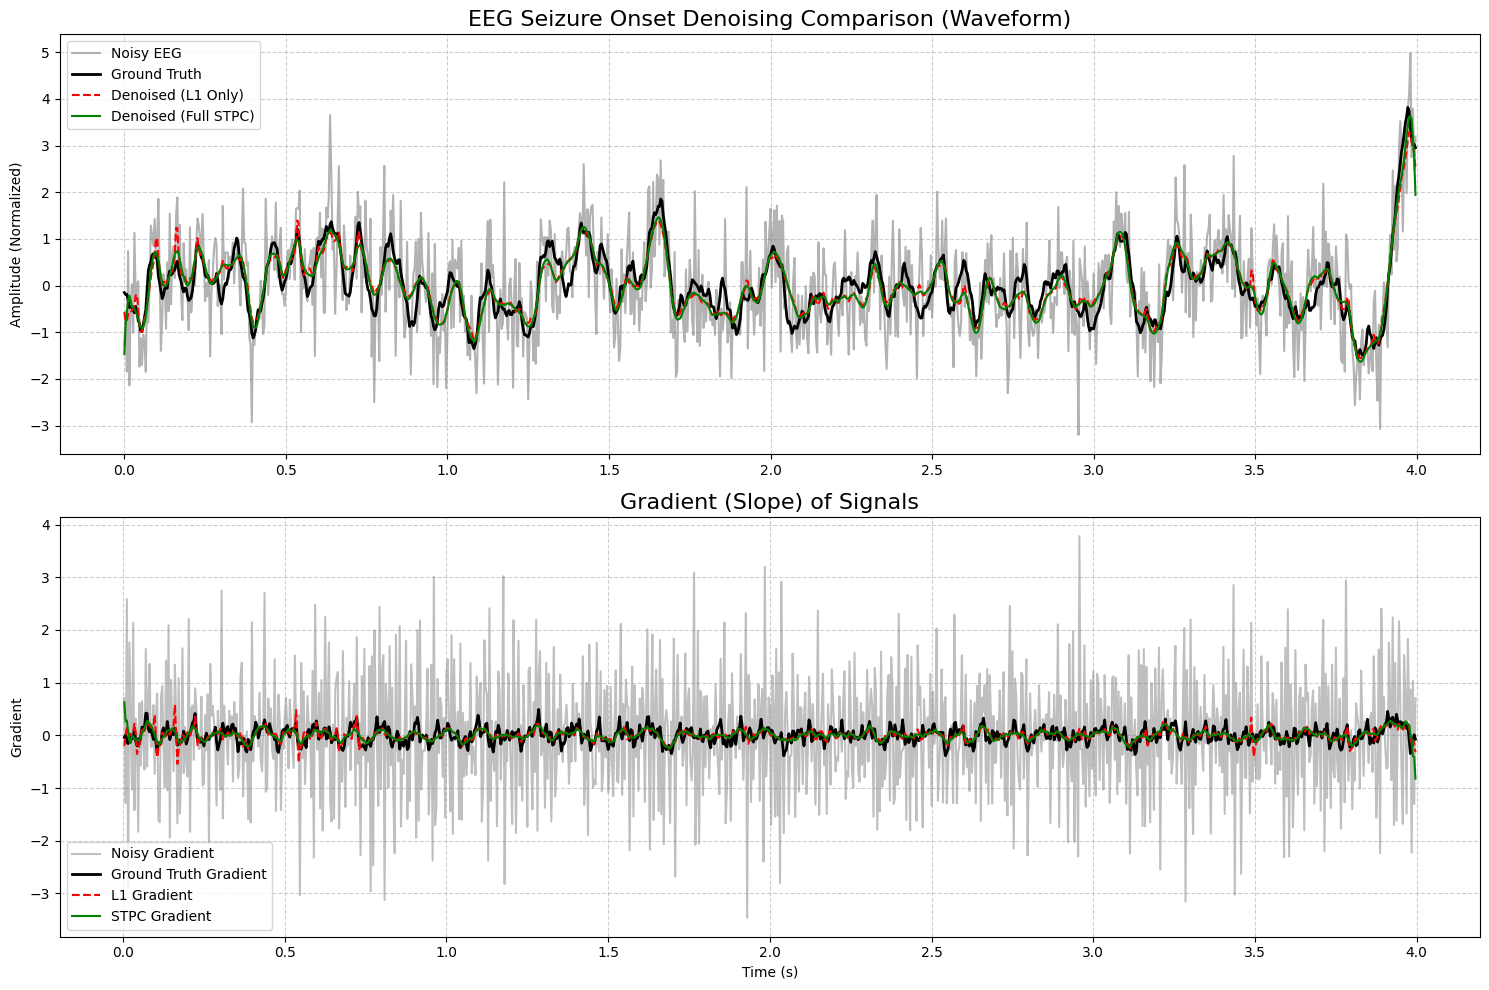


✅ EEG Generalization study complete. The plot 'eeg_gradient_preservation_plot.png' has been saved.


In [ ]:
# --- Training Function ---
def train_model(model, use_stpc=False):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_l1 = nn.L1Loss()
    loss_grad = GradientLoss()
    loss_fft = FFTLoss()

    print(f"\n--- Training model with STPC={'Enabled' if use_stpc else 'Disabled'} ---")
    for epoch in range(TRAINING_EPOCHS):
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TRAINING_EPOCHS}")
        for noisy, clean in loop:
            noisy, clean = noisy.to(DEVICE), clean.to(DEVICE)
            optimizer.zero_grad()
            denoised = model(noisy)

            # Calculate loss
            total_loss = loss_l1(denoised, clean)
            if use_stpc:
                total_loss += 0.5 * loss_grad(denoised, clean)
                total_loss += 0.3 * loss_fft(denoised, clean)

            total_loss.backward()
            optimizer.step()
            loop.set_postfix(loss=total_loss.item())

# --- Run the EEG experiment ---
model_l1 = UNet1D().to(DEVICE)
model_stpc = UNet1D().to(DEVICE)

train_model(model_l1, use_stpc=False)
train_model(model_stpc, use_stpc=True)

# --- Generate the final "Gradient Preservation Plot" ---
print("\n--- Generating final comparison plot ---")
model_l1.eval()
model_stpc.eval()

# Extract a sharp spike from the beginning of the seizure
spike_start = seizure_start_sample + int(0.5 * TARGET_FS)
spike_end = spike_start + SEGMENT_SAMPLES
clean_spike = eeg_signal[spike_start:spike_end]
noise = np.random.randn(len(clean_spike)) * np.mean(np.abs(clean_spike)) * 1.5 # High noise
noisy_spike = clean_spike + noise

with torch.no_grad():
    noisy_tensor = torch.from_numpy(noisy_spike).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    denoised_l1 = model_l1(noisy_tensor).squeeze().cpu().numpy()
    denoised_stpc = model_stpc(noisy_tensor).squeeze().cpu().numpy()

# Plotting
time = np.arange(SEGMENT_SAMPLES) / TARGET_FS
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title("EEG Seizure Onset Denoising Comparison (Waveform)", fontsize=16)
plt.plot(time, noisy_spike, 'gray', alpha=0.6, label='Noisy EEG')
plt.plot(time, clean_spike, 'k', linewidth=2, label='Ground Truth')
plt.plot(time, denoised_l1, 'r--', label='Denoised (L1 Only)')
plt.plot(time, denoised_stpc, 'g', label='Denoised (Full STPC)')
plt.legend()
plt.ylabel("Amplitude (Normalized)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 1, 2)
plt.title("Gradient (Slope) of Signals", fontsize=16)
plt.plot(time[1:], np.diff(noisy_spike), 'gray', alpha=0.5, label='Noisy Gradient')
plt.plot(time[1:], np.diff(clean_spike), 'k', linewidth=2, label='Ground Truth Gradient')
plt.plot(time[1:], np.diff(denoised_l1), 'r--', label='L1 Gradient')
plt.plot(time[1:], np.diff(denoised_stpc), 'g', label='STPC Gradient')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Gradient")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("eeg_gradient_preservation_plot.png")
plt.show()

print("\n✅ EEG Generalization study complete. The plot 'eeg_gradient_preservation_plot.png' has been saved.")